# Modelling dam volumes using DEA waterbodies

**Products used:** 
- [DE Africa Waterbodies](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html)
- [Department of Water Affairs and Sanitation, South Africa Dam Level and Volume Data](https://www.dws.gov.za/Hydrology/Verified/hymain.aspx)

## Background
This notebook outlines a detailed process for predicting dam levels and volumes based on water surface area data obtained from DE Africa's Waterbodies product. The model applies several steps such as data preprocessing, feature extraction, and Gradient Boosting model training to make predictions. The key focus of this analysis is to ensure the accuracy and reliability of predictions by implementing a correction mechanism to account for unrealistic large drops in dam volume predictions.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import joblib
import xarray as xr
import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objects as go
import datacube
from deafrica_tools.waterbodies import get_waterbody, get_time_series, display_time_series
from IPython.display import Image


### Analysis parameters
This section defines the analysis parameters, including:
* `waterbody_geohash`: Unique identifier (uid) / [geohash](https://en.wikipedia.org/wiki/Geohash) a waterbody.  The geohash of a water body is derived from its position, and this process can be reversed to obtain the location from the geohash. A waterbody's geohash is contained under the `uid` attribute and can be obtained through DE Africa Maps by clicking on a waterbody.

For this model development we will train and test for Loskop dam in South Africa with a DEA Water Body Geohash of:


In [2]:
waterbody_geohash = "kekz70yc3g"

## Get data for a specific waterbody

The returned GeoDataFrame includes the metadata for the selected waterbody including the id, uid, wb_id, area, perimeter and length. See the [Waterbodies Historical Extent documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html#Waterbodies-Historical-Extent) for descriptions of each attribute.

In [3]:
waterbody = get_waterbody(waterbody_geohash)
waterbody

,id,wb_id,area_m2,length_m,uid,perim_m,last_obs_date,last_valid_obs_date,last_valid_obs,last_attrs_update_date,geometry
0,DEAfrica_Waterbodies.kekz70yc3g,156677,2.376900e+07,17768.411844,kekz70yc3g,84180,2025-02-07,2025-01-31,95.638016,2025-02-11,"POLYGON ((29.3196 -25.4105, 29.3199 -25.4105, ..."


Once the water body polygon is in memory, you can plot them directly, or explore them in an interactive window.

<Axes: >

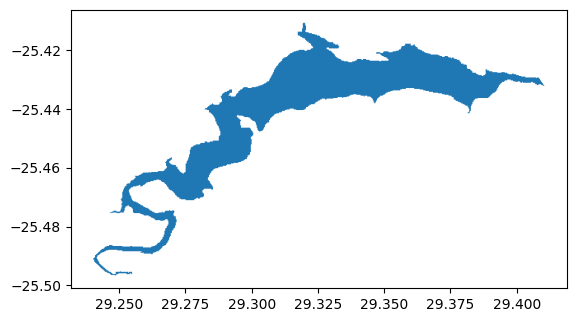

In [4]:
waterbody.plot()

In [5]:
waterbody.explore()

## Get the wet surface area time series for the selected waterbody

For any given waterbody, we can also use the `get_time_series()` function to get various measures of the water body surface over time. See the [Waterbodies Historical Extent documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html#Waterbodies-Surface-Area-Change) for descriptions of the different surface measures.

The function also calculates a rolling median of the water body surface wet percentage. This is used to visualise the overall trend in the surface wet percentage. The rolling median uses the last three observations to determine the median at a given date.

> By default the entire timeseries for the waterbody i.e. `start_date=1984-01-01` and `end_date=today` is loaded for the waterbody by the `get_time_series()` function  unless a filter is applied by passing the `start_date` and `end_date` parameters to the function.

In [6]:
waterbody_timeseries = get_time_series(waterbody=waterbody)
waterbody_timeseries

,area_wet_m2,percent_wet,area_dry_m2,percent_dry,area_invalid_m2,percent_invalid,area_observed_m2,percent_observed,percent_wet_rolling_median
date,,,,,,,,,
1984-08-18,297000.0,1.25,23427000.0,98.56,45000.0,0.19,23769000.0,100.0,NaN
1984-09-26,11171700.0,47.00,12497400.0,52.58,99900.0,0.42,23769000.0,100.0,NaN
1984-10-28,9899100.0,41.65,13634100.0,57.36,235800.0,0.99,23769000.0,100.0,41.65
1984-12-31,9563400.0,40.23,14160600.0,59.58,45000.0,0.19,23769000.0,100.0,41.65
1986-05-04,6759900.0,28.44,16479900.0,69.33,529200.0,2.23,23769000.0,100.0,40.23
...,...,...,...,...,...,...,...,...,...
2024-11-03,18011700.0,75.78,5700600.0,23.98,56700.0,0.24,23769000.0,100.0,85.03
2024-12-13,17187300.0,72.31,5810400.0,24.45,771300.0,3.24,23769000.0,100.0,75.78
2025-01-22,22927500.0,96.46,792000.0,3.33,49500.0,0.21,23769000.0,100.0,75.78


### Display the wet surface area time series for the selected waterbody

After loading the water body time series, we can use the `display_time_series()` function to create an interactive visualisation of the time series.

The visualisation shows the invalid percentage and the wet percentage. The invalid percentage indicates the proportion of the water body that couldn't be clearly observed. To provide the most representative measurements of water body surface area, the time series only contains values where the invalid percentage is lower than 10%.

There are some caveats to be aware of:

- To appear in the time series, an observation must record clear observations of at least 90% of the water body's surface area. If 10% or more of the surface area is covered by cloud or cloud shadow, the observation will be excluded. This can cause large gaps in the time series.
- If the invalid percentage is high, it's likely that the wet percentage is an underestimate of the true wet surface area.
- Annual and seasonal trends should only be inferred during times with sufficient observations. You should take care when infering the surface water change across time when there are few observations.
- The time series is based on the Water Observations from Space product, which has known limitations. See the [DE Africa Waterbodies service documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html) for more information.

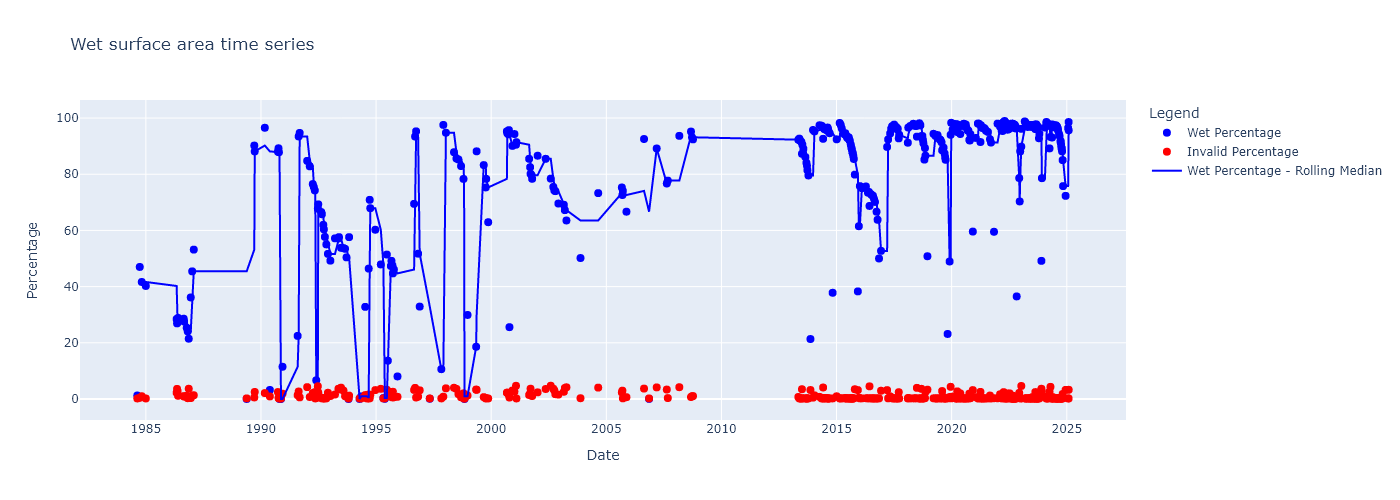

In [7]:
# Create a copy of the DataFrame with the index reset to avoid modifying the original
waterbody_timeseries_plot = waterbody_timeseries.reset_index()

# Create Plotly figure
fig = go.Figure()

# Add Wet Percentage trace
fig.add_trace(go.Scatter(x=waterbody_timeseries_plot['date'], 
                         y=waterbody_timeseries_plot['percent_wet'], 
                         mode='markers', 
                         name='Wet Percentage',
                         marker=dict(color='blue', size=8, symbol='circle')))

# Add Invalid Percentage trace
fig.add_trace(go.Scatter(x=waterbody_timeseries_plot['date'], 
                         y=waterbody_timeseries_plot['percent_invalid'], 
                         mode='markers', 
                         name='Invalid Percentage',
                         marker=dict(color='red', size=8, symbol='circle')))

# Add Rolling Median Wet Percentage trace
fig.add_trace(go.Scatter(x=waterbody_timeseries_plot['date'], 
                         y=waterbody_timeseries_plot['percent_wet_rolling_median'], 
                         mode='lines', 
                         name='Wet Percentage - Rolling Median',
                         line=dict(color='blue', width=2)))

# Update layout to make the width 100%
fig.update_layout(title='Wet surface area time series',
                  xaxis_title='Date',
                  yaxis_title='Percentage',
                  legend_title='Legend',
                  width=1400,  # Allow dynamic resizing
                  height=500)  # Set only the height

# Save the figure as a PNG image
image_path = "wet_surface_area_time_series_plotly.png"
fig.write_image(image_path)

# Display the saved image in the notebook
Image(filename=image_path)

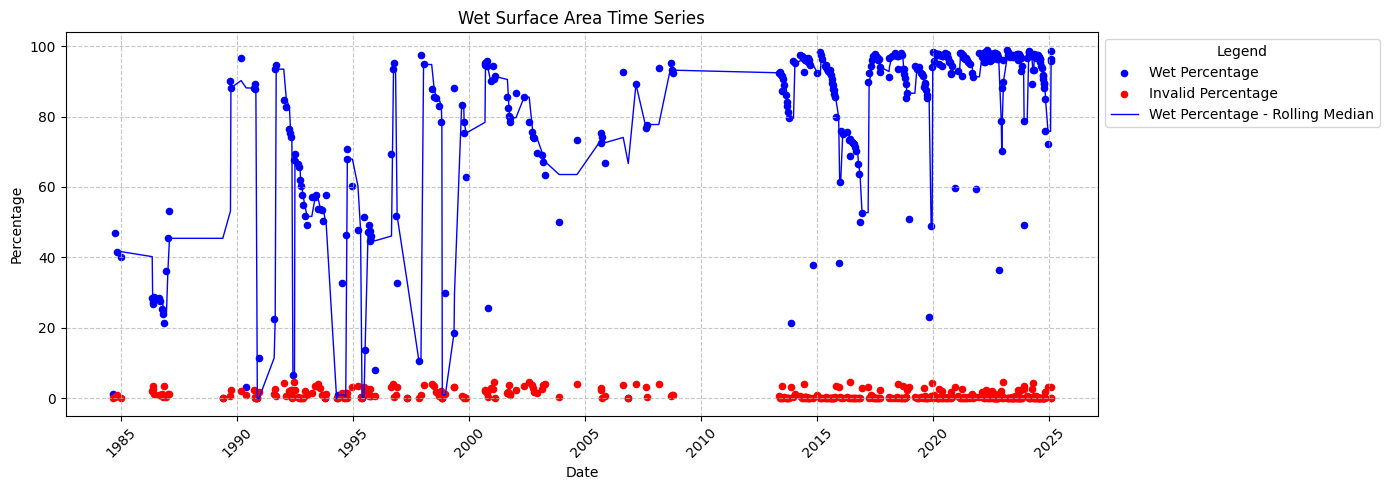

In [8]:



# Create a copy of the DataFrame with the index reset
waterbody_timeseries_plot = waterbody_timeseries.reset_index()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 5))

# Plot Wet Percentage
ax.scatter(waterbody_timeseries_plot['date'], waterbody_timeseries_plot['percent_wet'], 
           color='blue', label='Wet Percentage', s=20, marker='o')

# Plot Invalid Percentage
ax.scatter(waterbody_timeseries_plot['date'], waterbody_timeseries_plot['percent_invalid'], 
           color='red', label='Invalid Percentage', s=20, marker='o')

# Plot Rolling Median Wet Percentage
ax.plot(waterbody_timeseries_plot['date'], waterbody_timeseries_plot['percent_wet_rolling_median'], 
        color='blue', linewidth=1, label='Wet Percentage - Rolling Median')

# Set labels and title
ax.set_title('Wet Surface Area Time Series')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage')
plt.xticks(rotation=45)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save the figure as a PNG image
# image_path = "wet_surface_area_time_series_matplotlib.png"
# plt.savefig(image_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



## Load Model Training Datasets

#### Function to convert waterbody_timeseries into hectares based datatable 

In [9]:
def convert_to_hectare_table(waterbody_timeseries):
    # Create water_area_ha by dividing area_wet_m2 by 10,000 (conversion from square meters to hectares)
    waterbody_timeseries['water_area_ha'] = waterbody_timeseries['area_wet_m2'] / 10000

    # Prepare final table
    digital_twin_table = pd.DataFrame({
        'original_id': ['kekz70yc3g'] * len(waterbody_timeseries),
        'id': range(183875, 183875 + len(waterbody_timeseries)),
        'waterbody_id': [518] * len(waterbody_timeseries),  # Assuming a constant waterbody_id as per Limpopo Digital Twin
        'date': waterbody_timeseries.index,  # Assuming 'date' is the index of the waterbody_timeseries
        'water_area_ha': waterbody_timeseries['water_area_ha'],
        'percent_invalid': waterbody_timeseries['percent_invalid']
    })
    return digital_twin_table

# Call the conversion function on the waterbody_timeseries to replace the old water levels data loading
water_areas_ha = convert_to_hectare_table(waterbody_timeseries)
water_areas_ha

,original_id,id,waterbody_id,date,water_area_ha,percent_invalid
date,,,,,,
1984-08-18,kekz70yc3g,183875,518,1984-08-18,29.70,0.19
1984-09-26,kekz70yc3g,183876,518,1984-09-26,1117.17,0.42
1984-10-28,kekz70yc3g,183877,518,1984-10-28,989.91,0.99
1984-12-31,kekz70yc3g,183878,518,1984-12-31,956.34,0.19
1986-05-04,kekz70yc3g,183879,518,1986-05-04,675.99,2.23
...,...,...,...,...,...,...
2024-11-03,kekz70yc3g,184273,518,2024-11-03,1801.17,0.24
2024-12-13,kekz70yc3g,184274,518,2024-12-13,1718.73,3.24
2025-01-22,kekz70yc3g,184275,518,2025-01-22,2292.75,0.21


In [10]:
dam_attributes = pd.read_csv('data/dam_attributes/dam_attributes.csv')
rating_curve = pd.read_csv('data/DWS/rating_curve.csv')
daily_volumes = pd.read_csv('data/DWS/daily_volumes.csv')


### Sample Data Overview

This dataset contains raw water levels data collected from DEA (Department of Environmental Affairs). Below is a sample from the dataset:


In [11]:
water_areas_ha

,original_id,id,waterbody_id,date,water_area_ha,percent_invalid
date,,,,,,
1984-08-18,kekz70yc3g,183875,518,1984-08-18,29.70,0.19
1984-09-26,kekz70yc3g,183876,518,1984-09-26,1117.17,0.42
1984-10-28,kekz70yc3g,183877,518,1984-10-28,989.91,0.99
1984-12-31,kekz70yc3g,183878,518,1984-12-31,956.34,0.19
1986-05-04,kekz70yc3g,183879,518,1986-05-04,675.99,2.23
...,...,...,...,...,...,...
2024-11-03,kekz70yc3g,184273,518,2024-11-03,1801.17,0.24
2024-12-13,kekz70yc3g,184274,518,2024-12-13,1718.73,3.24
2025-01-22,kekz70yc3g,184275,518,2025-01-22,2292.75,0.21


In [12]:
dam_attributes

,parameter,unit name,unit symbol,value,description
0,inflow_elevation,meters above sea level,m,1025.00,Bed elevation of the river at the dam inflow
1,outflow_elevation,meters above sea level,m,962.00,Elevation of the riverbed at the dam's outflow...
2,vertical_drop,meters,m,63.00,Vertical elevation difference between the infl...
3,distance_along_river,meters,m,23302.00,Thalweg distance between the inflow and outflo...
4,slope,percentage,%,0.27,The percentage of vertical drop per unit of ho...
5,direct_distance,meters,m,13162.00,Direct linear distance between the inflow and ...
6,full_capacity_elevation,meters above sea level,m,1001.00,Elevation of the water surface at the maximum ...
7,maximum_depth,meters,m,36.00,Greatest vertical distance between the water s...
8,mean_depth,meters,m,15.43,Average vertical distance between the water su...
9,full_surface_area,hectares,ha,2199.69,Total surface area of the water body at full s...


#### Extract dam attributes
The full value indicator i.e. the value representing the dam at 100% capacity for both the volume and the area were found to be a strong feature for training the model and acting as a baseline starting point.

In [13]:
full_volume = dam_attributes[dam_attributes['parameter'] == 'full_volume']['value'].values[0]
full_surface_area = dam_attributes[dam_attributes['parameter'] == 'full_surface_area']['value'].values[0]
full_dam_level = dam_attributes[dam_attributes['parameter'] == 'full_dam_level']['value'].values[0]
maximum_dam_level = dam_attributes[dam_attributes['parameter'] == 'maximum_dam_level']['value'].values[0]
capacity_of_spillway = dam_attributes[dam_attributes['parameter'] == 'capacity_of_spillway']['value'].values[0]
vertical_drop = dam_attributes[dam_attributes['parameter'] == 'vertical_drop']['value'].values[0]
mean_depth = dam_attributes[dam_attributes['parameter'] == 'mean_depth']['value'].values[0]
full_capacity_elevation = dam_attributes[dam_attributes['parameter'] == 'full_capacity_elevation']['value'].values[0]
shoreline_length = dam_attributes[dam_attributes['parameter'] == 'shoreline_length']['value'].values[0]
maximum_volume = dam_attributes[dam_attributes['parameter'] == 'maximum_volume']['value'].values[0]
maximum_surface_area = dam_attributes[dam_attributes['parameter'] == 'maximum_surface_area']['value'].values[0]


In [14]:
rating_curve

,water_level,volume_mcm
0,1.78,0.001981
1,1.79,0.059259
2,1.80,0.116598
3,1.81,0.173998
4,1.82,0.231459
...,...,...
2819,29.97,403.761877
2820,29.98,403.991116
2821,29.99,404.220417
2822,30.00,404.449778


In [15]:
daily_volumes

,Date,COR_LEVEL,COR_FLOW,Dam_Level,Volume_mcm
0,2000-01-01,-5.119000,0.000000,22.961000,258.074527
1,2000-01-02,-4.996000,0.000000,23.084000,260.316284
2,2000-01-03,-4.161000,0.000000,23.919000,276.254542
3,2000-01-04,-3.027000,0.000000,25.053000,298.374261
4,2000-01-05,-2.305500,0.000000,25.774500,312.874508
...,...,...,...,...,...
8310,2024-02-29,0.045937,4.228750,28.125937,362.620104
8311,2024-03-01,0.050000,4.794286,28.130000,362.620104
8312,2024-03-02,0.049000,4.645364,28.129000,362.620104
8313,2024-03-03,0.046000,4.209593,28.126000,362.620104


### Data Preprocessing

In the data preprocessing stage, it was crucial to handle potential outliers in the water area dataset, which could negatively impact model accuracy. We applied the **Interquartile Range (IQR) method** to systematically identify and remove these outliers.

The IQR method flags data points that lie beyond 1.5 times the interquartile range (IQR), calculated as the distance between the first quartile (Q1) and the third quartile (Q3). Any values falling below Q1 or above Q3 by more than 1.5 times the IQR were considered outliers. Removing these extreme values helped ensure that the model was trained on reliable, realistic water area measurements, improving its robustness and generalizability.

To account for seasonal variability, the IQR method was applied on a per-month basis, ensuring that seasonal changes did not distort the detection process.

**Key steps:**
- Remove outliers per month using the IQR method.
- Handle missing values by dropping rows containing `NaN` in critical feature columns, such as `water_area_ha`.

---

#### Filter water levels based on percentage invalid
- Filter out rows where the percent_invalid is greater than 10.
- Calculate and print the number of samples removed during the filtering process.
- Print the number of samples remaining in the dataset after the filtering.

In [16]:
initial_count = len(water_areas_ha)
water_areas_filtered = water_areas_ha[water_areas_ha['percent_invalid'] <= 0.5]
final_count = len(water_areas_filtered)
removed_count = initial_count - final_count
print(f"Number of samples removed: {removed_count}")
print(f"Number of samples remaining: {final_count}")

Number of samples removed: 159
Number of samples remaining: 244


#### Convert date columns to datetime

In [17]:
water_areas_filtered = water_areas_filtered.copy()
daily_volumes = daily_volumes.copy()
water_areas_filtered['date'] = pd.to_datetime(water_areas_filtered['date'])
daily_volumes['Date'] = pd.to_datetime(daily_volumes['Date'])

#### Remove outliers per month using the IQR method

During the data preprocessing step, it is crucial to remove outliers that could negatively impact the accuracy of the model. To do this, the **Interquartile Range (IQR) method** is applied. Outliers are detected and removed if they lie beyond 1.5 times the interquartile range (IQR).

The IQR method operates using the following equation:

$$
IQR = Q_3 - Q_1
$$

Where:
- $Q_1$ is the first quartile (25th percentile).
- $Q_3$ is the third quartile (75th percentile).

Outliers are any data points that fall below the lower bound or above the upper bound:

$$
\text{Lower Bound} = Q_1 - 1.5 \times IQR
$$
$$
\text{Upper Bound} = Q_3 + 1.5 \times IQR
$$

These outliers are removed on a monthly basis to account for seasonal variations in the dataset.

---

In [18]:
original_count = len(daily_volumes)
trimmed_observed = daily_volumes[daily_volumes['Volume_mcm'] <= maximum_volume]
trimmed_count = len(trimmed_observed)
removed_samples = original_count - trimmed_count
print(f"Number of samples removed: {removed_samples}")
print(f"Valid number of samples: {original_count - removed_samples}")
trimmed_observed

Number of samples removed: 16
Valid number of samples: 8299


,Date,COR_LEVEL,COR_FLOW,Dam_Level,Volume_mcm
0,2000-01-01,-5.119000,0.000000,22.961000,258.074527
1,2000-01-02,-4.996000,0.000000,23.084000,260.316284
2,2000-01-03,-4.161000,0.000000,23.919000,276.254542
3,2000-01-04,-3.027000,0.000000,25.053000,298.374261
4,2000-01-05,-2.305500,0.000000,25.774500,312.874508
...,...,...,...,...,...
8310,2024-02-29,0.045937,4.228750,28.125937,362.620104
8311,2024-03-01,0.050000,4.794286,28.130000,362.620104
8312,2024-03-02,0.049000,4.645364,28.129000,362.620104
8313,2024-03-03,0.046000,4.209593,28.126000,362.620104


In [19]:
water_areas_filtered['date'] = pd.to_datetime(water_areas_filtered['date'], errors='coerce')
water_areas_filtered['month'] = water_areas_filtered['date'].dt.month

def calculate_min_surface_area(df, full_volume, minimum_volume, maximum_surface_area):
    volume_percentage_diff = (maximum_volume - minimum_volume) / maximum_volume    
    min_surface_area_estimate =  (maximum_surface_area * (1 - volume_percentage_diff))    
    print(f"Full Supply Volume: {full_volume:.2f} million m³")
    print(f"Minimum Volume: {minimum_volume:.2f} million m³")
    print(f"Full Supply Surface Area: {full_surface_area:.2f} ha")
    print(f"Estimated Minimum Surface Area: {min_surface_area_estimate:.2f} ha")    
    initial_count = len(df)
    df_filtered = df[(df['water_area_ha'] >= min_surface_area_estimate)]
    removed_count = initial_count - len(df_filtered)    
    print(f"Number of values removed based on min and max thresholds: {removed_count}")
    print(f"Remaining samples after threshold filtering: {len(df_filtered)}")
    
    return df_filtered

minimum_volume = trimmed_observed['Volume_mcm'].min()
water_areas_filtered = calculate_min_surface_area(water_areas_filtered, maximum_volume, minimum_volume, maximum_surface_area)

def remove_outliers_per_month(df):
    cleaned_data = df.copy()
    total_initial_samples = len(cleaned_data)
    
    removed_outliers_count = 0
    for month, group in df.groupby('month'):
        Q1 = group['water_area_ha'].quantile(0.25)
        Q3 = group['water_area_ha'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR        
        outliers = group[
            (group['water_area_ha'] < lower_bound) | 
            (group['water_area_ha'] > upper_bound)
        ]
        removed_outliers_count += len(outliers)
        cleaned_data.loc[group.index, 'water_area_ha'] = group[
            (group['water_area_ha'] >= lower_bound) & 
            (group['water_area_ha'] <= upper_bound)
        ]['water_area_ha']
    
    remaining_after_outliers = len(cleaned_data.dropna(subset=['water_area_ha']))    
    print(f"Total initial samples: {total_initial_samples}")
    print(f"Number of samples removed due to outliers: {removed_outliers_count}")
    print(f"Number of samples remaining after outlier removal: {remaining_after_outliers}")
    
    return cleaned_data

water_areas_cleaned = remove_outliers_per_month(water_areas_filtered)
initial_cleaned_count = len(water_areas_cleaned)
water_areas_cleaned.dropna(subset=['water_area_ha'], inplace=True)
final_cleaned_count = len(water_areas_cleaned)

samples_removed_nan = initial_cleaned_count - final_cleaned_count
print(f"Number of samples removed due to NaN: {samples_removed_nan}")
print(f"Number of samples remaining after dropping NaN values: {final_cleaned_count}")


Full Supply Volume: 385.84 million m³
Minimum Volume: 94.95 million m³
Full Supply Surface Area: 2199.69 ha
Estimated Minimum Surface Area: 597.45 ha
Number of values removed based on min and max thresholds: 20
Remaining samples after threshold filtering: 224
Total initial samples: 224
Number of samples removed due to outliers: 24
Number of samples remaining after outlier removal: 200
Number of samples removed due to NaN: 24
Number of samples remaining after dropping NaN values: 200


### Model preperation and Training

#### Calculate Dam Level Based on Surface Area Using Power Coefficient

The **dam level** (or height of water in the dam) can be estimated using a power-law relationship between the surface area and the level. This relationship assumes that as the surface area increases, the dam level increases at a nonlinear rate, which is determined by a power coefficient derived from the reservoir's geometry or rating curve.

The formula for calculating the dam level is:

$$
L = \left( \frac{A}{A_{\text{full}}} \right)^{\frac{1}{n}} \times L_{\text{full}}
$$

Where:
- $L$ is the **calculated dam level** (height of water) in meters.
- $A$ is the current water surface area in hectares.
- $A_{\text{full}}$ is the full surface area of the reservoir in hectares.
- $L_{\text{full}}$ is the dam level at full capacity.
- $n$ is the power coefficient, which is derived from the rating curve and represents how the surface area changes with the dam level.

In this case, the power coefficient $n$ is dynamically calculated from the reservoir's rating curve data, which reflects the relationship between water surface area and dam level. This dynamic approach allows for a more accurate estimation of the reservoir's dam level based on its current surface area.


In [20]:
def power_law(x, c, n):
    return c * np.power(x, n)

water_level = rating_curve['water_level'].values
volume_mcm = rating_curve['volume_mcm'].values
low_volume_threshold = trimmed_observed['Volume_mcm'].quantile(0.25)
low_volume_mask = (volume_mcm <= low_volume_threshold)
filtered_water_level_low = water_level[low_volume_mask]
filtered_volume_mcm_low = volume_mcm[low_volume_mask]

if len(filtered_water_level_low) >= 2:
    params_low, _ = curve_fit(power_law, filtered_water_level_low, filtered_volume_mcm_low, p0=[1, 1])
    c_fitted_low, n_fitted_low = params_low
    print(f"Low Volume Fit - c: {c_fitted_low}, n: {n_fitted_low}")
else:
    raise ValueError("Not enough data points to fit the low-volume power law.")

mid_high_volume_mask = (volume_mcm > low_volume_threshold)
filtered_water_level_mid_high = water_level[mid_high_volume_mask]
filtered_volume_mcm_mid_high = volume_mcm[mid_high_volume_mask]

if len(filtered_water_level_mid_high) >= 2:
    params_mid_high, _ = curve_fit(power_law, filtered_water_level_mid_high, filtered_volume_mcm_mid_high, p0=[1, 1])
    c_fitted_mid_high, n_fitted_mid_high = params_mid_high
    print(f"Mid-High Volume Fit - c: {c_fitted_mid_high}, n: {n_fitted_mid_high}")
else:
    raise ValueError("Not enough data points to fit the mid-to-high-volume power law.")


Low Volume Fit - c: 1.592006898422042, n: 1.623453513389123
Mid-High Volume Fit - c: 1.301014533115113, n: 1.6873461044016285


#### Use the Power Coefficient for Level Calculation

Once the power coefficient is calculated dynamically from the rating curve, it can be used to estimate the **dam level** based on the current water surface area. This is done using the inverse power law formula:

**Calculate Dam Level from Surface Area**

The dam level can be estimated from the surface area using the following relationship:

$$
L_{\text{calculated}} = \left( \frac{A_{\text{current}}}{A_{\text{full}}} \right)^{\frac{1}{n}} \times L_{\text{full}}
$$

Where:
- $L_{\text{calculated}}$ is the estimated **dam level**.
- $A_{\text{current}}$ is the current water surface area.
- $A_{\text{full}}$ is the full surface area of the dam at maximum capacity.
- $n$ is the power coefficient calculated from the rating curve data.
- $L_{\text{full}}$ is the **full dam level** at maximum capacity.

### Explanation:
- **`water_area_ha`**: The current surface area in hectares.
- **`full_surface_area`**: The surface area of the dam at 100% capacity (maximum water surface area), which is extracted from the dam attributes.
- **`full_dam_level`**: The height of the water body at maximum capacity (when the dam is full).
- **`n_fitted`**: The power coefficient that describes how the surface area changes with dam level. This coefficient is derived from the rating curve using a power-law relationship.

This coefficient is derived from the power-law relationship between the water level at the dam wall and the surface area of the reservoir. It is used to estimate changes in dam level as a function of surface area. By leveraging this coefficient, we can estimate the water level based on the surface area, assuming that the surface area scales predictably with the dam level.

This relationship is particularly useful when direct measurements of water level are unavailable, but surface area data is available (e.g., from satellite imagery).


In [21]:
# Assert conditions
assert maximum_surface_area > 0, "maximum_surface_area must be greater than 0."
assert maximum_dam_level > 0, "maximum_dam_level must be greater than 0."
assert 'c_fitted_low' in globals() and 'n_fitted_low' in globals(), "Low-volume power-law parameters must be defined."
assert 'c_fitted_mid_high' in globals() and 'n_fitted_mid_high' in globals(), "Mid-to-high-volume power-law parameters must be defined."

# Clean up the water_areas_cleaned DataFrame
if 'date' in water_areas_cleaned.columns:
    water_areas_cleaned = water_areas_cleaned.drop(columns=['date']).copy(deep=True)  # Make a deep copy

if 'date' not in water_areas_cleaned.columns:
    water_areas_cleaned = water_areas_cleaned.reset_index(drop=False).copy(deep=True)  # Make a deep copy after reset_index

if 'date' not in water_areas_cleaned.columns:
    print(f"'date' column not found. Current columns: {water_areas_cleaned.columns}")

# Make a distinct deep copy of the DataFrame to avoid any unwanted views
water_areas_cleaned = water_areas_cleaned.copy(deep=True)

# Function to calculate dam level from surface area
def calculate_level_from_area(area_ha, volume_threshold, c_low, n_low, c_mid_high, n_mid_high):
    if area_ha <= volume_threshold:
        return (area_ha / maximum_surface_area) ** (1 / n_low) * maximum_dam_level
    else:
        return (area_ha / maximum_surface_area) ** (1 / n_mid_high) * maximum_dam_level

# Apply the calculation function to the water_area_ha column
water_areas_cleaned['calculated_level'] = water_areas_cleaned['water_area_ha'].apply(
    lambda area: calculate_level_from_area(area, low_volume_threshold, c_fitted_low, n_fitted_low, c_fitted_mid_high, n_fitted_mid_high)
)

# Make an explicit deep copy of trimmed_observed to avoid any slices
trimmed_observed = trimmed_observed.copy(deep=True)
# Convert 'Date' column in trimmed_observed DataFrame to datetime
trimmed_observed.loc[:, 'Date'] = pd.to_datetime(trimmed_observed['Date'])

# Ensure 'date' is in datetime format in water_areas_cleaned
if 'date' in water_areas_cleaned.columns:
    # Use .loc to modify 'date' safely, ensuring no warning
    water_areas_cleaned.loc[:, 'date'] = pd.to_datetime(water_areas_cleaned['date'])
else:
    raise KeyError("'date' column not found in water_areas_cleaned")

# Merge the two DataFrames on their date columns
merged_data = pd.merge(trimmed_observed, water_areas_cleaned, left_on='Date', right_on='date', how='inner')
merged_data


,Date,COR_LEVEL,COR_FLOW,Dam_Level,Volume_mcm,date,original_id,id,waterbody_id,water_area_ha,percent_invalid,month,calculated_level
0,2003-11-18,-14.018000,0.000000,14.062000,116.295956,2003-11-18,kekz70yc3g,183998,518,1192.77,0.27,11,19.150135
1,2005-09-20,-6.479021,0.000000,21.600979,233.281855,2005-09-20,kekz70yc3g,184002,518,1760.67,0.23,9,24.121315
2,2007-09-03,-5.232114,0.000000,22.847886,256.027299,2007-09-03,kekz70yc3g,184008,518,1847.52,0.33,9,24.819551
3,2013-05-21,-1.594000,0.000000,26.486000,327.690982,2013-05-21,kekz70yc3g,184014,518,2203.02,0.19,5,27.547962
4,2013-07-08,-2.320000,0.000000,25.760000,312.670950,2013-07-08,kekz70yc3g,184018,518,2151.54,0.20,7,27.164617
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2023-09-30,-0.385000,0.000000,27.695000,353.087834,2023-09-30,kekz70yc3g,184231,518,2293.83,0.19,9,28.215396
155,2023-10-08,-0.470500,0.000000,27.609500,351.367382,2023-10-08,kekz70yc3g,184232,518,2298.24,0.19,10,28.247532
156,2023-10-24,-0.685763,0.000000,27.394237,346.656270,2023-10-24,kekz70yc3g,184234,518,2244.51,0.22,10,27.854269
157,2024-02-13,0.157088,26.597324,28.237088,365.021625,2024-02-13,kekz70yc3g,184238,518,2343.69,0.19,2,28.577277


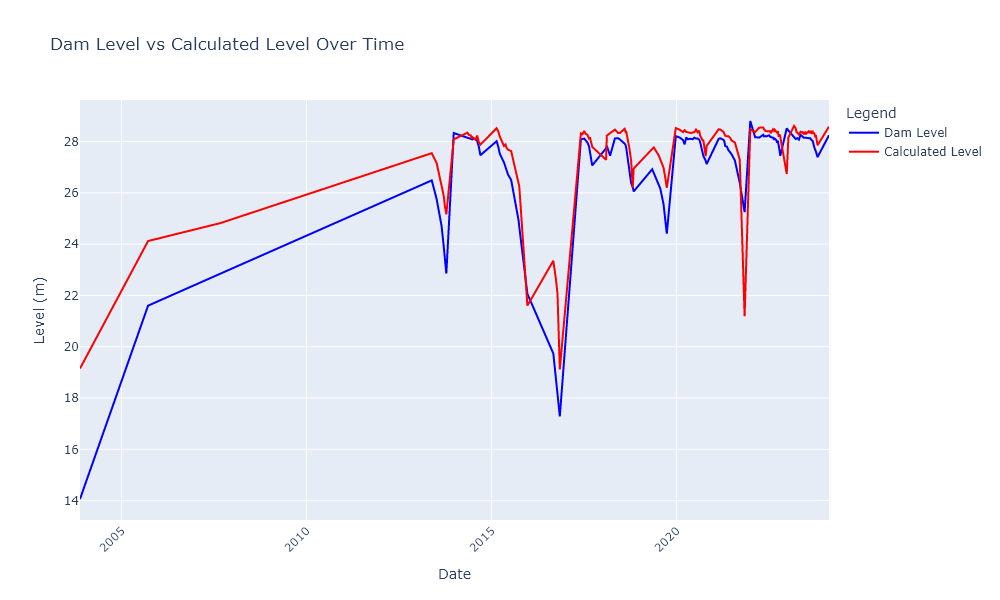

In [22]:
# Create the figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_data['Date'], 
                         y=merged_data['Dam_Level'], 
                         mode='lines', 
                         name='Dam Level', 
                         line=dict(color='blue')))

fig.add_trace(go.Scatter(x=merged_data['Date'], 
                         y=merged_data['calculated_level'], 
                         mode='lines', 
                         name='Calculated Level', 
                         line=dict(color='red')))

fig.update_layout(title='Dam Level vs Calculated Level Over Time',
                  xaxis_title='Date',
                  yaxis_title='Level (m)',
                  legend_title='Legend',
                  xaxis=dict(tickangle=-45),
                  height=600,
                  width=1000)

# Save the figure as a PNG image
image_path = "dam_levels_chart.png"
fig.write_image(image_path)

# Display the saved image in the notebook
Image(filename=image_path)

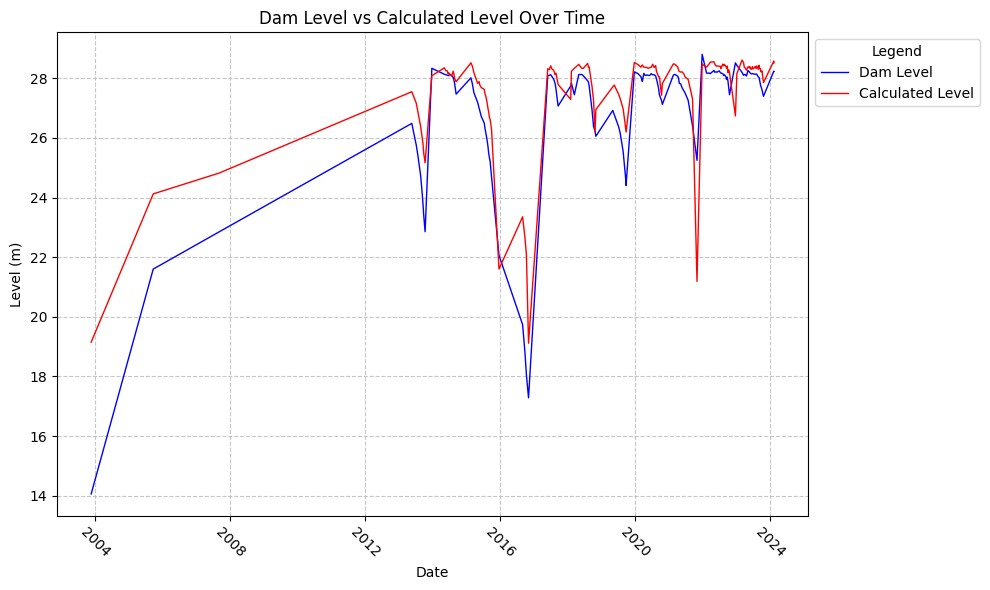

In [23]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Dam Level
ax.plot(merged_data['Date'], merged_data['Dam_Level'], 
        label='Dam Level', color='blue', linewidth=1)

# Plot Calculated Level
ax.plot(merged_data['Date'], merged_data['calculated_level'], 
        label='Calculated Level', color='red', linewidth=1)

# Set title and labels
ax.set_title('Dam Level vs Calculated Level Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Level (m)')
plt.xticks(rotation=-45)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save the figure as a PNG image
# image_path = "dam_levels_chart_matplotlib.png"
# plt.savefig(image_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


#### Define Features and Target for Model Training

Since we are trying to predict the **dam level** (`Dam_Level`), the target variable needs to reflect the observed dam level.

- **Features**: The input variables used to predict the dam level. In this case, the features include:
  - `calculated_level`: The estimated dam level, calculated using the power-law relationship between volume and dam level.
  - `water_area_ha`: The current water surface area in hectares.

- **Target**: The output variable the model will try to predict, which in this case is the **dam level** (`Dam_Level`).

This is implemented with the following code:

In [24]:
print("Preparing features and target for model training...")
merged_data['full_volume'] = full_volume
merged_data['full_surface_area'] = full_surface_area
merged_data['full_dam_level'] = full_dam_level
merged_data['maximum_dam_level'] = maximum_dam_level
merged_data['capacity_of_spillway'] = capacity_of_spillway
merged_data['vertical_drop'] = vertical_drop
merged_data['mean_depth'] = mean_depth
merged_data['full_capacity_elevation'] = full_capacity_elevation
merged_data['shoreline_length'] = shoreline_length
merged_data['maximum_volume'] = maximum_volume
merged_data['maximum_surface_area'] = maximum_surface_area

merged_data

Preparing features and target for model training...


,Date,COR_LEVEL,COR_FLOW,Dam_Level,Volume_mcm,date,original_id,id,waterbody_id,water_area_ha,...,full_surface_area,full_dam_level,maximum_dam_level,capacity_of_spillway,vertical_drop,mean_depth,full_capacity_elevation,shoreline_length,maximum_volume,maximum_surface_area
0,2003-11-18,-14.018000,0.000000,14.062000,116.295956,2003-11-18,kekz70yc3g,183998,518,1192.77,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7
1,2005-09-20,-6.479021,0.000000,21.600979,233.281855,2005-09-20,kekz70yc3g,184002,518,1760.67,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7
2,2007-09-03,-5.232114,0.000000,22.847886,256.027299,2007-09-03,kekz70yc3g,184008,518,1847.52,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7
3,2013-05-21,-1.594000,0.000000,26.486000,327.690982,2013-05-21,kekz70yc3g,184014,518,2203.02,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7
4,2013-07-08,-2.320000,0.000000,25.760000,312.670950,2013-07-08,kekz70yc3g,184018,518,2151.54,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2023-09-30,-0.385000,0.000000,27.695000,353.087834,2023-09-30,kekz70yc3g,184231,518,2293.83,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7
155,2023-10-08,-0.470500,0.000000,27.609500,351.367382,2023-10-08,kekz70yc3g,184232,518,2298.24,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7
156,2023-10-24,-0.685763,0.000000,27.394237,346.656270,2023-10-24,kekz70yc3g,184234,518,2244.51,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7
157,2024-02-13,0.157088,26.597324,28.237088,365.021625,2024-02-13,kekz70yc3g,184238,518,2343.69,...,2199.69,28.08,29.18,7750.0,63.0,15.43,1001.0,69300.0,385.84,2427.7


### Data Preparation and Feature Selection
This section involves selecting the relevant features and handling missing values.

In [25]:
features = merged_data[['calculated_level', 'water_area_ha']]
target = merged_data['Dam_Level']
print(f"Initial data shape: {features.shape}")
print(f"Missing values in features:\n{features.isnull().sum()}")

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

features_imputed_df = pd.DataFrame(features_imputed, columns=features.columns)
print(f"Data shape after imputing missing values: {features_imputed_df.shape}")

Initial data shape: (159, 2)
Missing values in features:
calculated_level    0
water_area_ha       0
dtype: int64
Data shape after imputing missing values: (159, 2)


### Splitting Data for Training and Testing
Here, we split the data into training and test sets.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features_imputed_df, target, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Training set size: 127 rows
Test set size: 32 rows


### Performing Cross-Validation
This step involves evaluating the model using cross-validation.

In [27]:
print("Performing cross-validation...")
gradient_boosting = GradientBoostingRegressor(random_state=42)
cv_scores = cross_val_score(gradient_boosting, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores).mean()
print(f"Cross-validated RMSE: {cv_rmse:.4f}")

Performing cross-validation...
Cross-validated RMSE: 0.7095


### Hyperparameter Tuning
We perform hyperparameter tuning using GridSearchCV to find the best combination of parameters for the Gradient Boosting Regressor.

In [28]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
print("Performing hyperparameter tuning using GridSearchCV...")
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Performing hyperparameter tuning using GridSearchCV...
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}


### Training the Best Model
We now train the model with the optimal hyperparameters found in the previous step.

In [29]:
print("\nTraining the best model with optimal hyperparameters...")
best_model.fit(X_train, y_train)
print("Model training completed.")


Training the best model with optimal hyperparameters...
Model training completed.


### Model Evaluation
We evaluate the trained model on the test dataset using RMSE, MAPE, and R² Score as performance metrics.

In [30]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"\nModel evaluation results:\n - RMSE: {rmse:.4f}\n - MAPE: {mape:.4f}\n - R² Score: {r2:.4f}")



Model evaluation results:
 - RMSE: 0.2615
 - MAPE: 0.0063
 - R² Score: 0.9164


### Feature Importances
We analyze the importance of each feature to understand how much each one contributed to the model's predictions.

In [31]:
print("\nFeature Importances:")
feature_importances = best_model.feature_importances_
for feature, importance in zip(features.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")


Feature Importances:
Feature: calculated_level, Importance: 0.5550
Feature: water_area_ha, Importance: 0.4450


### Saving the Trained Model
We save the trained model for future use.

In [32]:
print("\nSaving the trained model...")
os.makedirs("trained_models", exist_ok=True)
model_path = "trained_models/gradient_boosting_model.pkl"
joblib.dump(best_model, model_path)
print(f"Trained model saved successfully at: {model_path}")


Saving the trained model...
Trained model saved successfully at: trained_models/gradient_boosting_model.pkl


#### Predict Dam Levels and Convert to Volumes Using the Rating Curve

After training the Gradient Boosting Regressor model, the next step is to predict the **dam levels** for the entire dataset and convert both the predicted and observed dam levels into corresponding **water volumes** using the **rating curve**.

Once the model is trained, we use it to predict the dam levels based on the input features (`calculated_level` and `water_area_ha`). The predicted dam levels are stored in `y_pred_full`:


In [33]:
y_pred_full = best_model.predict(features_imputed_df)

#### Plot observed vs predicted levels over time

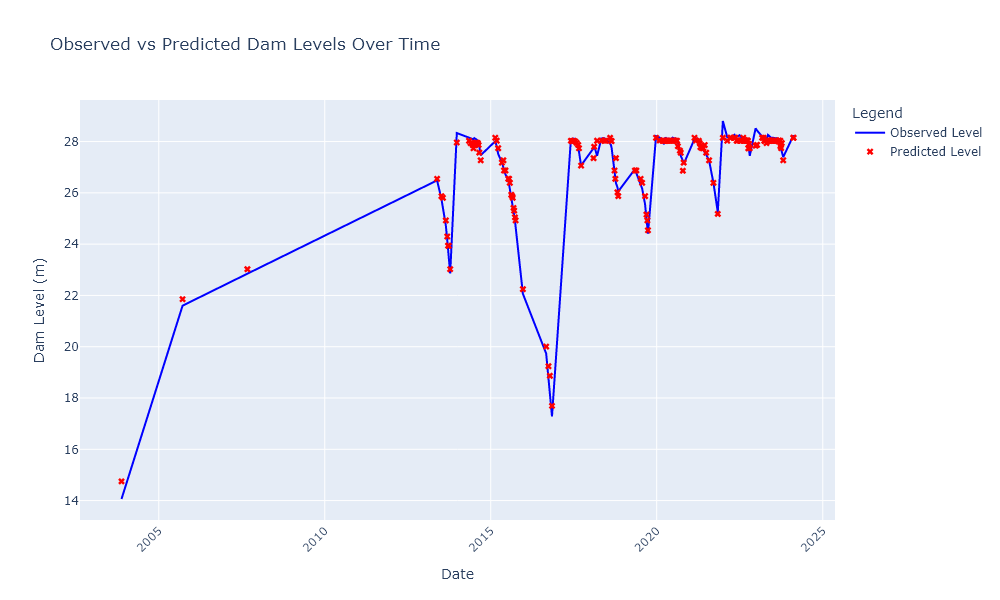

In [34]:
# Create the dataframes
observed_levels_df = pd.DataFrame({
    'Date': merged_data['Date'],
    'Observed Level': merged_data['Dam_Level']
})

predicted_levels_df = pd.DataFrame({
    'Date': merged_data['Date'],
    'Predicted Level': y_pred_full
})

# Create Plotly figure
fig = go.Figure()

# Add Observed Level trace
fig.add_trace(go.Scatter(x=observed_levels_df['Date'], 
                         y=observed_levels_df['Observed Level'], 
                         mode='lines', 
                         name='Observed Level', 
                         line=dict(color='blue')))

# Add Predicted Level trace
fig.add_trace(go.Scatter(x=predicted_levels_df['Date'], 
                         y=predicted_levels_df['Predicted Level'], 
                         mode='markers', 
                         name='Predicted Level', 
                         marker=dict(color='red', symbol='x')))

# Update layout
fig.update_layout(title='Observed vs Predicted Dam Levels Over Time',
                  xaxis_title='Date',
                  yaxis_title='Dam Level (m)',
                  legend_title='Legend',
                  xaxis=dict(tickangle=-45),
                  height=600,
                  width=1000)

# Save the figure as a PNG image
image_path = "observed_vs_predicted_dam_levels.png"
fig.write_image(image_path)

# Display the saved image in the notebook
Image(filename=image_path)

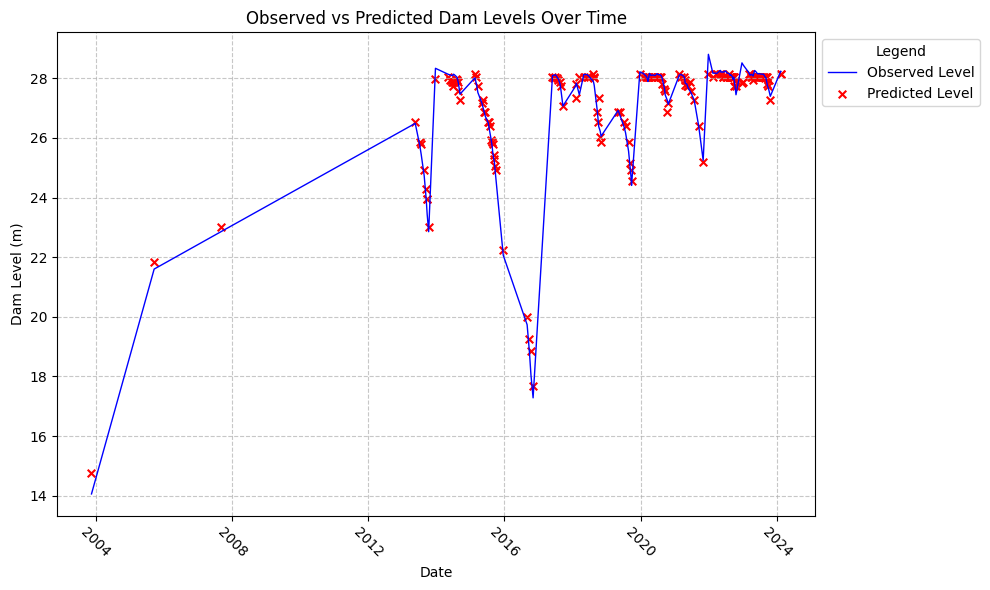

In [35]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Observed Level
ax.plot(observed_levels_df['Date'], observed_levels_df['Observed Level'], 
        label='Observed Level', color='blue', linewidth=1)

# Plot Predicted Level (using scatter for markers)
ax.scatter(predicted_levels_df['Date'], predicted_levels_df['Predicted Level'], 
           label='Predicted Level', color='red', marker='x', s=30)

# Set title and labels
ax.set_title('Observed vs Predicted Dam Levels Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Dam Level (m)')
plt.xticks(rotation=-45)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save the figure as a PNG image
# image_path = "observed_vs_predicted_dam_levels_matplotlib.png"
# plt.savefig(image_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


#### Evaluate the performance of the predicted levels vs. observed levels against entire dataset

In [36]:
mse_full = mean_squared_error(target, y_pred_full)
rmse_full = np.sqrt(mse_full)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_full = mean_absolute_percentage_error(target, y_pred_full)
r2_full = r2_score(target, y_pred_full)
print(f"{'RMSE':<10} {'MAPE':<10} {'R² Score':<10}")
print(f"{rmse_full:<10.4f} {mape_full:<10.2f} {r2_full:<10.4f}")

RMSE       MAPE       R² Score  
0.2220     0.62       0.9897    


### Prediction Refinement

#### Dam level volume interpolation

Next, we use the rating curve to map the **dam levels** to **volumes**. The rating curve provides a relationship between **dam level** and **volume** for the reservoir, and we use interpolation to make this mapping. The `interpolate.interp1d` function is used to create a mapping from dam levels to volumes:

In [37]:
rating_curve_interp_volume = interpolate.interp1d(rating_curve['water_level'], rating_curve['volume_mcm'], fill_value="extrapolate")

This interpolation allows us to take both the observed dam levels (target.values) and the predicted dam levels (y_pred_full) and convert them into volumes using the rating curve:

In [38]:
observed_volumes_full = rating_curve_interp_volume(target.values)
predicted_volumes_full = rating_curve_interp_volume(y_pred_full)

#### Calculate Maximum Percentage Drop Between Consecutive Actual Volume Readings

##### Why We Do This:
- **Identify Realistic Drops**: By calculating the maximum percentage drop between consecutive readings, we can identify what levels of volume depletion are realistically expected. This helps distinguish between normal variations and extreme cases.
  
- **Model Correction**: If the model drastically under-predicts volumes (for example, when predicted volumes show unrealistically large drops), this analysis allows us to apply corrections. By identifying the normal range of percentage drops, we can use this information to adjust the model predictions and prevent unrealistic under-predictions.

- **Improve Prediction Accuracy**: Understanding typical percentage drops between readings enables us to refine the model. If predicted drops fall outside of expected ranges, corrective actions can be taken, ensuring that model outputs better match observed patterns.

- The percentage drop between consecutive actual readings is calculated by comparing the current volume with the previous volume. The formula used is:

$$
\text{percentDrop} = \frac{(\text{previous}_{volume} - \text{current}_{volume})}{\text{previous}_{volume}} \times 100
$$


- This calculates how much the volume has decreased as a percentage of the previous volume

This step is crucial to maintain the reliability of model outputs and ensure that predicted water volumes remain realistic based on historical trends and known behavior of water depletion in the dam.

In [39]:
daily_volumes = daily_volumes.sort_values(by='Date')
daily_volumes['previous_volume'] = daily_volumes['Volume_mcm'].shift(1)
daily_volumes['percent_drop'] = (daily_volumes['previous_volume'] - daily_volumes['Volume_mcm']) / daily_volumes['previous_volume'] * 100
max_percent_drop = daily_volumes['percent_drop'].max()
print(f"Max Percent Drop between actual readings: {max_percent_drop}%")

Max Percent Drop between actual readings: 4.11120333501487%


#### Creating Predicted Data and Applying the Maximum Percent Drop Rule

In this section, we first create the `predicted_data` DataFrame, which stores the predicted dam volumes along with their corresponding dates. The predicted volumes are derived from earlier model outputs based on observed water levels. 

The main purpose of this step is to apply a validation rule known as the **maximum percent drop rule**. This rule ensures that the predicted volumes do not show unrealistic, sharp declines between consecutive data points, especially when there are large time gaps between observations. By comparing the predicted dam volume at each time step with the previous one, the rule checks if the drop in volume exceeds the maximum percentage drop observed historically. If the actual drop exceeds this threshold, the predicted volume is adjusted to fall within reasonable limits.

To account for varying time gaps between readings, the **median time difference** between consecutive observations is calculated and used to apply the rule only when the time difference between consecutive readings is smaller than or equal to this median. This helps ensure that the predicted dam volumes are consistent with the natural behavior of water level changes over time, particularly in cases where data points are sparse and sporadic.

Finally, the rule is applied to the `predicted_data`, correcting any instances where the predicted drop in volume is considered unrealistic, maintaining the integrity and accuracy of the predictions.


In [40]:
predicted_data = pd.DataFrame({
    'date': merged_data['Date'],
    'Predicted_Dam_Volume': predicted_volumes_full
})

def apply_max_percent_drop_rule(data, max_percent_drop, median_time_diff):
    data = data.sort_values(by='date')
    
    for i in range(1, len(data)):
        prev_value = data.iloc[i-1]['Predicted_Dam_Volume']
        curr_value = data.iloc[i]['Predicted_Dam_Volume']
        time_diff = (data.iloc[i]['date'] - data.iloc[i-1]['date']).days
        
        if time_diff <= median_time_diff and curr_value < prev_value:
            max_allowed_drop = prev_value * (max_percent_drop / 100.0)
            if (prev_value - curr_value) > max_allowed_drop:
                # Adjust the predicted volume to enforce the rule
                data.at[data.index[i], 'Predicted_Dam_Volume'] = prev_value - max_allowed_drop
    
    return data

daily_volumes['time_diff_days'] = daily_volumes['Date'].diff().dt.days
median_time_diff = daily_volumes['time_diff_days'].median()
predicted_data = apply_max_percent_drop_rule(predicted_data, max_percent_drop, median_time_diff)

#### Evaluate the performance of the predicted volumes vs. observed volumes

In [41]:
observed_volumes = merged_data['Volume_mcm'].values
predicted_volumes = predicted_data['Predicted_Dam_Volume'].values

min_length = min(len(observed_volumes), len(predicted_volumes))
observed_volumes = observed_volumes[:min_length]
predicted_volumes = predicted_volumes[:min_length]

mse_volumes = mean_squared_error(observed_volumes, predicted_volumes)

rmse_volumes = np.sqrt(mse_volumes)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_volumes = mean_absolute_percentage_error(observed_volumes, predicted_volumes)

r2_volumes = r2_score(observed_volumes, predicted_volumes)

# Output results
print(f"{'Metric':<10} {'RMSE':<10} {'MAPE':<10} {'R² Score':<10}")
print(f"{'Volumes':<10} {rmse_volumes:<10.4f} {mape_volumes:<10.2f} {r2_volumes:<10.4f}")

Metric     RMSE       MAPE       R² Score  
Volumes    4.4692     1.04       0.9884    


#### Plot observed vs predicted volumes over time

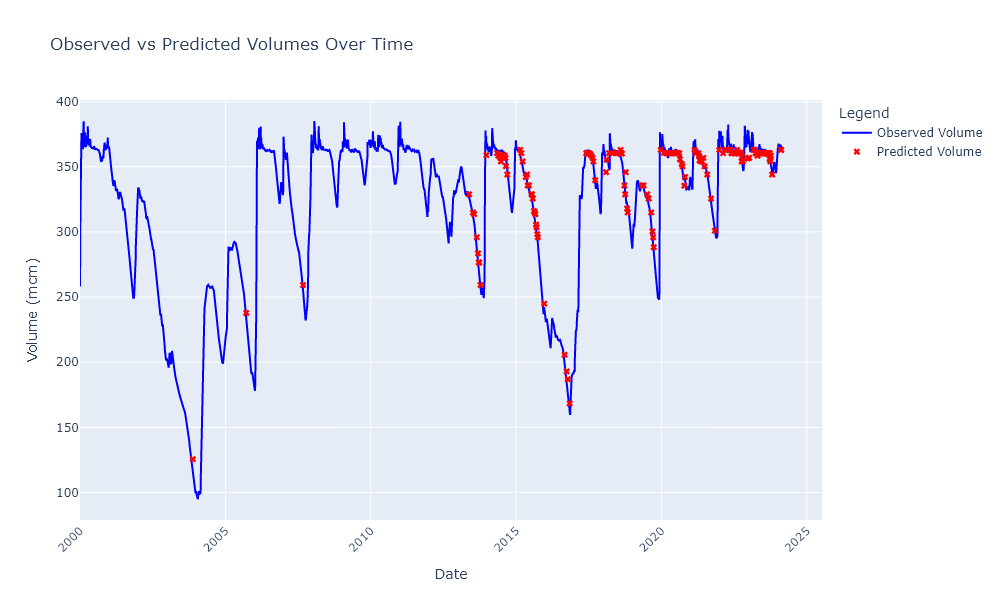

In [42]:
# Create the dataframes
observed_volumes_full_df = pd.DataFrame({
    'Date': trimmed_observed['Date'],
    'Observed Volume': trimmed_observed['Volume_mcm']
})

predicted_volumes_full_df = pd.DataFrame({
    'Date': merged_data['Date'],
    'Predicted Volume': predicted_volumes_full
})

# Create Plotly figure
fig = go.Figure()

# Add Observed Volume trace
fig.add_trace(go.Scatter(x=observed_volumes_full_df['Date'], 
                         y=observed_volumes_full_df['Observed Volume'], 
                         mode='lines', 
                         name='Observed Volume', 
                         line=dict(color='blue')))

# Add Predicted Volume trace
fig.add_trace(go.Scatter(x=predicted_volumes_full_df['Date'], 
                         y=predicted_volumes_full_df['Predicted Volume'], 
                         mode='markers', 
                         name='Predicted Volume', 
                         marker=dict(color='red', symbol='x')))

# Update layout
fig.update_layout(title='Observed vs Predicted Volumes Over Time',
                  xaxis_title='Date',
                  yaxis_title='Volume (mcm)',
                  legend_title='Legend',
                  xaxis=dict(tickangle=-45),
                  height=600,
                  width=1000)

# Save the figure as a PNG image
image_path = "observed_vs_predicted_volumes.png"
fig.write_image(image_path)

# Display the saved image in the notebook
Image(filename=image_path)

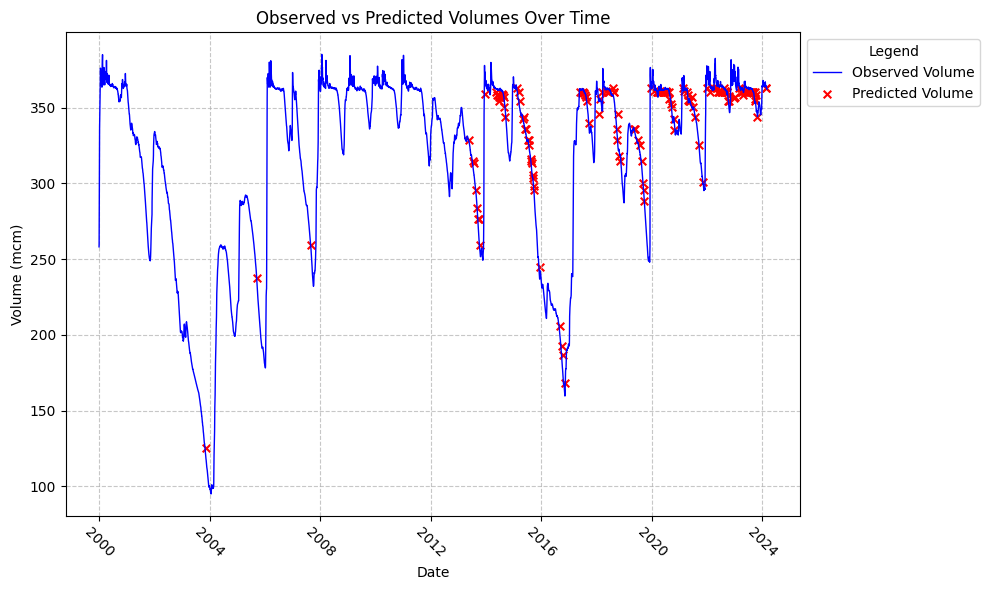

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Observed Volume
ax.plot(observed_volumes_full_df['Date'], observed_volumes_full_df['Observed Volume'], 
        label='Observed Volume', color='blue', linewidth=1)

# Plot Predicted Volume (using scatter for markers)
ax.scatter(predicted_volumes_full_df['Date'], predicted_volumes_full_df['Predicted Volume'], 
           label='Predicted Volume', color='red', marker='x', s=30)

# Set title and labels
ax.set_title('Observed vs Predicted Volumes Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Volume (mcm)')

# Rotate x-axis labels
plt.xticks(rotation=-45)

# Move legend outside the plot
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save the figure as a PNG image
# image_path = "observed_vs_predicted_volumes_matplotlib.png"
# plt.savefig(image_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


#### Store the results

In [44]:

output_data = pd.merge(observed_volumes_full_df, predicted_volumes_full_df, on='Date', how='left')
os.makedirs("results", exist_ok=True)
output_data.to_csv('results/volume_predictions.csv', index=False)


## Additional information

**License:**  
The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).  
The data used in this notebook, including dam levels and surface area data, is subject to licensing by respective data providers. Where applicable, Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:**  
If you need assistance with this notebook, you can:
- Contact ................................
- Post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/).
- Ask a question on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag. View previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube).

For reporting an issue or suggesting improvements, file one on [GitHub](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**  
This notebook is compatible with `datacube` version `1.8.19` and Python version `3.11.x` or higher. It is recommended to update your environment for compatibility with the latest `scikit-learn` and `pandas` versions to avoid deprecation warnings.

---

## Embed into project background: 
The CGIAR Digital Innovation Initiative accelerates the transformation towards sustainable and inclusive agrifood systems by generating research-based evidence and innovative digital solutions. It is one of 32 initiatives of CGIAR, a global research partnership for a food-secure future, dedicated to transforming food, land, and water systems in a climate crisis.
 
**Add to references:**
- Garcia Andarcia, M., Dickens, C., Silva, P., Matheswaran, K., & Koo, J. (2024). Digital Twin for management of water resources in the Limpopo River Basin: a concept. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 4p.
- Gurusinghe, T., Muthuwatta, L., Matheswaran, K., & Dickens, C. (2024). Developing a foundational hydrological model for the Limpopo River Basin using the Soil and Water Assessment Tool Plus (SWAT+). Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 14p.
- Leitão, P. C., Santos, F., Barreiros, D., Santos, H., Silva, P., Madushanka, T., Matheswaran, K., Mutuwatte, L., Vickneswaran, K., Retief, H., Dickens, C., Garcia Andarcia, M. (2024). Operational SWAT+ Model: Advancing Seasonal Forecasting in the Limpopo River Basin. Colombo, Sri Lanka:  International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation.
- Mallick, Archita & Ghosh, Surajit & De Sarkar, Kounik & Roy, Sudip. (2024). Reservoir Water Level Forecasting using Deep Learning Technique. Conference: 2024 IEEE India Geoscience and Remote Sensing Symposium


### Contributors

**Mariangel Garcia Andarcia**  
*Research Group Leader*  
Email: [m.garciaandarcia@cgiar.org](mailto:m.garciaandarcia@cgiar.org)

**Chris Dickens**  
*Principal Researcher*  
Email: [c.dickens@cgiar.org](mailto:c.dickens@cgiar.org)

**Hugo Retief**  
*Researcher*  
Email: [hugo@award.org.za](mailto:hugo@award.org.za)

**Victoria Neema**  
*Earth Observation Scientist*  
Email: [victoria.neema@digitalearthafrica.org](mailto:victoria.neema@digitalearthafrica.org)

---

**Last Tested:**

In [45]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-02-11'